The goal of this exercise is to determine the risk of a person in developing a Cardiovascular Disease (CVD), such as heart attacks, based on features of their personal lifestyle factors.  
Respondents (participants) were classified as having coronary heart disease (MICHD) if they reported having been tol by a provider they had MICH or if they reported having been told they had a heart attacks or angina.  

It is our job to use the data to build a model able to estimate the likelihood of developing MICHD given a certain clinical and lifestyle situation.  

x_train and x_test : each row corresponds to a person and each column to an health related data  
y_train : Id = correspond to data ID in x_train ; 1 = the person have a MICHD ; -1 = the person does not have a MICHD

In [2]:
import os
os.chdir('c:\\Users\\utilisateur\\Documents\\GitHub\\ML_Project1\\ML_project1')
         
import sys
sys.path.append(os.getcwd())

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
from preprocess import *
from implementationsnils import *

%load_ext autoreload
%autoreload 2


In [2]:
from helpers import load_csv_data

# load data.
data_path = '/Users/nilsmanni/Desktop/MA_3/ML/Proj_1_local/dataset/'
#data_path = './dataset/'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)


## Data Preprocessing ##  

1. Select only the column that might have a correlation to the output (based on personal knowledge or assumption)

In [3]:
selected_columns = [
    "CVDINFR4", "CVDCRHD4", "CVDSTRK3", "BPHIGH4", "TOLDHI2", "DIABETE3",
    "SMOKE100", "SMOKDAY2", "ALCDAY5", "EXERANY2", "FRUIT1", "VEGETAB1",
    "SEX", "AGE", "INCOME2", "EDUCA", "BMI", "GENHLTH", "PHYSHLTH", 
    "MENTHLTH", "POORHLTH", "CHECKUP1", "BPMEDS", "BLOODCHO", "CHOLCHK", 
    "TOLDHI2", "ASTHMA3", "ASTHNOW", "CHCSCNCR", "CHCOCNCR", "CHCCOPD1",
    "ADDEPEV2", "CHCKIDNY", "EMPLOY1", "WEIGHT2", "HEIGHT3", "DIFFWALK",
    "AVEDRNK2", "FVGGREEN", "EXERHMM1", "PREDIAB1", "QLMENTL2", "QLSTRES2",
    "CVDASPRN", "SCNTMNY1"
]

# Open the CSV file
with open('/Users/nilsmanni/Desktop/MA_3/ML/Proj_1_local/dataset/x_train.csv', newline='', encoding='utf-8') as csvfile:
    # Read the CSV file
    columns_name = csvfile.readline().strip().split(',')

# Indices of the columns to conserve
indices_colonnes = [columns_name.index(col) for col in selected_columns if col in columns_name]
x_train = np.genfromtxt('/Users/nilsmanni/Desktop/MA_3/ML/Proj_1_local/dataset/x_train.csv', delimiter=',', skip_header=1, usecols=indices_colonnes, dtype=float)
x_test = np.genfromtxt('/Users/nilsmanni/Desktop/MA_3/ML/Proj_1_local/dataset/x_test.csv', delimiter=',', skip_header=1, usecols=indices_colonnes, dtype=float)

2. Do the whole pre-processing pipeline with the function "Preprocess_Data"

In [4]:
x_train, x_val, y_train, y_val, x_test_final = Preprocess_Data(
    file_path=data_path,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test, 
    test_size=0.8,                  # Use 20% of data as test set
    balance_method="undersample",    # Choose to undersample for balancing
    missing_val_threshold=0.25,      # Remove columns with >25% missing data
    variance_threshold=0.01,         # Minimum variance threshold
    low_corr_threshold=0.05,         # Minimum correlation threshold with target
    high_corr_threshold=0.9,         # Maximum correlation threshold between features
    p_value_threshold=0.05           # p-value threshold for statistical significance
)

Variance thresholding: 5 features removed with variance below 0.01


In [4]:
print(x_train.shape)

(46360, 130)


## Model Training ##  

 The final score result can be compute when putting the y predicted from the x_test on the internet page for ranking. 
Scores selected should be : F1_score, accuracy, loss

We start by converting y_train and y_val to binary values (0,1) instead of (-1,1) in order to compare them to our future predictions.

In [5]:
# Convert y_train and y_val labels to binary (1, 0) for future comparison
y_train_bin = np.where(y_train == -1, 0, 1)
y_val_bin = np.where(y_val == -1, 0, 1)

**1. Gradient Descent method**   

The methods seem to diverge if gamma is above 0.5. Try several number between 0 and 0.5 and keep the best results. .

In [6]:
#Gradient descent method: 

gammas = [1e-2, 1e-1, 2e-1, 3e-1]
max_iters_list = [50, 100, 150, 200]

#Best Hyperparameter variables
best_f1 = 0
best_gamma = None
best_max_iters = None
best_loss = None
best_accuracy = None
best_w_GD = None  # Initialize best weights

#Change binary values (-1, 1) of y to binary values (0, 1) for classification
y_train_bin = np.where(y_train == -1, 0, 1)
y_val_bin = np.where(y_val == -1, 0, 1)

training_losses = np.zeros([len(max_iters_list), len(gammas)])

validation_f1 = np.zeros([len(max_iters_list), len(gammas)])
validation_losses = np.zeros([len(max_iters_list), len(gammas)])
validation_accuracies = np.zeros((len(max_iters_list), len(gammas)))

#Test on the different gammas and iterations
for gamma in gammas:
    for max_iters in max_iters_list:
        #Weights initialization
        initial_w = np.zeros((x_train.shape[1]))   

        #Train the model on current hyperparameters
        w, train_loss = mean_squares_error_gd(y_train_bin, x_train, initial_w, max_iters, gamma)

        #Prediction on the validation set
        y_val_pred = np.dot(x_val, w)
        y_val_pred_prob = sigmoid(y_val_pred)
        y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion to 0 or 1
        
        #F1_score and accuracy calculation on validation set
        f1 = f1_score(y_val_bin, y_val_pred)
    
        accuracy = np.mean(y_val_pred == y_val_bin)
        val_loss = np.mean((y_val_pred - y_val_bin) ** 2)  # MSE for validation set

        training_losses[max_iters_list.index(max_iters), gammas.index(gamma)] = train_loss
        
        validation_f1 [max_iters_list.index(max_iters), gammas.index(gamma)] = f1
        validation_losses[max_iters_list.index(max_iters), gammas.index(gamma)] = val_loss
        validation_accuracies[max_iters_list.index(max_iters), gammas.index(gamma)] = accuracy
        
        #Update the best hyperparameter if the F1_score is higher 
        if f1 > best_f1:
            best_f1 = f1
            best_gamma = gamma
            best_max_iters = max_iters
            best_loss = val_loss
            best_accuracy = accuracy
            best_w_GD = w
            
            
print("Best weights :", best_w_GD) 
print("Best gamma :", best_gamma)
print("Best iteration :", best_max_iters)
print("Best F1 score on validation set :", best_f1)
print("Best accuracy on validation set:", best_accuracy)
print("Best loss on validation :", best_loss)

Best weights : [-3.07134473e-04 -1.59618520e-03 -2.58652849e-06  2.67343513e-03
  2.67343513e-03 -2.13967225e-02 -2.70093839e-02  3.12704908e-02
  3.47652579e-02 -3.44453064e-02 -9.38057110e-03  2.02461827e-02
  3.28189099e-04  2.97527180e-02  5.62360568e-02 -1.58773352e-02
  2.82761091e-04  4.59270471e-02 -3.72513985e-03 -3.71003851e-03
 -2.10751496e-02 -3.02872270e-03  2.16181653e-02  2.07135626e-02
 -6.39725984e-03  6.15230550e-04  5.32415865e-03  1.65967621e-02
  3.88012974e-02 -1.11242622e-03 -3.75600107e-02  1.08257712e-02
 -6.71551372e-04 -3.45850378e-03  1.25352365e-03  2.92794452e-03
  2.96870201e-02 -1.97615232e-02  1.44015422e-03  1.73825253e-02
  7.57580175e-03 -1.20587504e-02  2.02161875e-02  8.48277252e-03
 -1.56763262e-02  1.24120723e-02  1.38112747e-02  7.64578503e-03
 -2.50690141e-04  9.66881753e-03  5.81894398e-04  1.23448331e-02
  3.30229150e-03  2.16888101e-03  2.84597325e-03  8.66211575e-03
 -1.80128998e-02  7.89221115e-03  6.61994790e-02  5.63676358e-02
  3.849186

/Users/nilsmanni/anaconda3/envs/SM4EO/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/nilsmanni/Desktop/MA_3/ML/ML_project1/implementationsnils.py:68: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(prev_loss-loss)<0.0000001:
/Users/nilsmanni/Desktop/MA_3/ML/ML_project1/implementationsnils.py:17: RuntimeWarning: overflow encountered in square
  loss = 1/(2*len(y))*np.sum((y - np.dot(tx, w))**2)


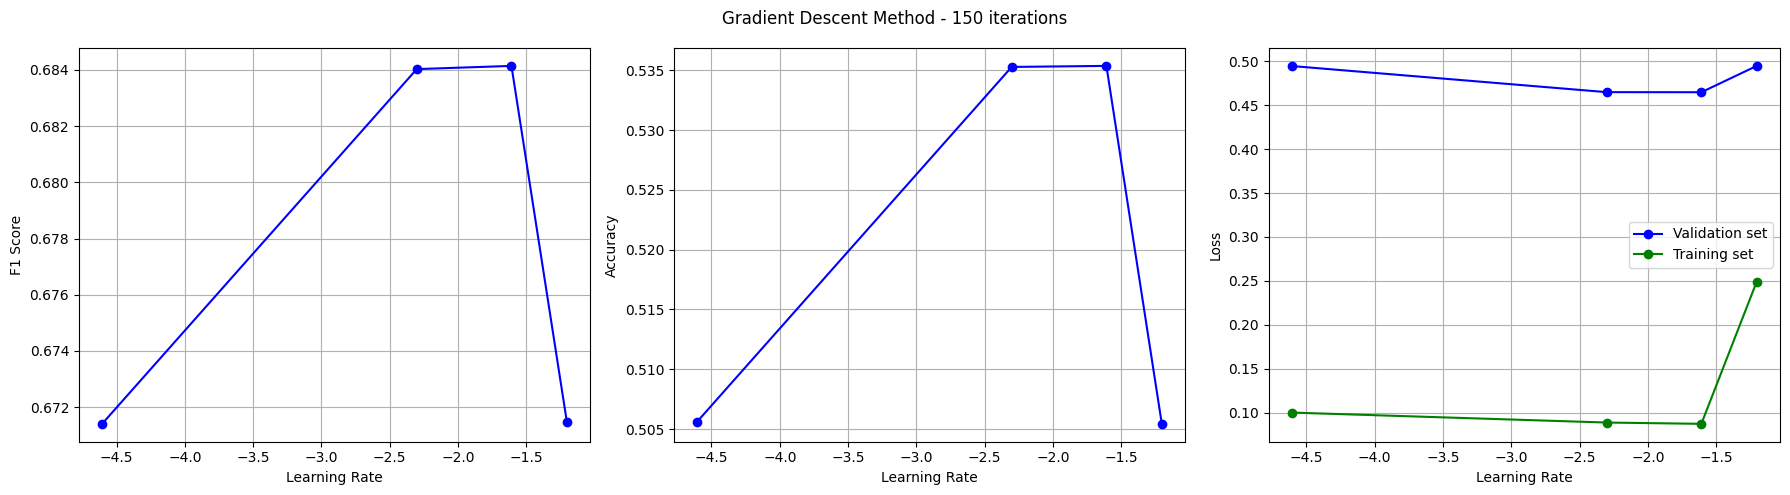

In [11]:
# Get the index for 150 iterations in max_iters_list
iter_index = max_iters_list.index(150)

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot F1 Score
axes[0].plot(np.log(gammas), validation_f1[iter_index, :], marker='o', color='b')
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("F1 Score")
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(np.log(gammas), validation_accuracies[iter_index, :], marker='o', color='b')
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)

# Plot Loss
axes[2].plot(np.log(gammas),  validation_losses[iter_index, :], marker='o', color='b', label='Validation set')
axes[2].plot(np.log(gammas),  training_losses[iter_index, :], marker='o', color='g', label ='Training set')
axes[2].set_xlabel("Learning Rate")
axes[2].set_ylabel("Loss")
axes[2].grid(True)
axes[2].legend()

# Adjust layout
fig.suptitle('Gradient Descent Method - 150 iterations')
plt.tight_layout()
plt.show()

**Overfitting** : if the training loss keep decreasing but the validation loss start to increase, overfitting is occuring.

 **2. Stochastic Gradient Descent method**  

The method does not seem to work for gamma above 0.1. So we selected different gamma between 0.00001 and 0.01. Indeed, the learning rate for the SGD is usually smaller than for GD because, because the weights are updated for each point of the dataset and so it allow to reduce the variations of the weight and converge more rapidly.

In [25]:
gammas = [1e-10, 1e-5, 1e-2]
max_iters = 100

#Best Hyperparameter variables
best_f1 = 0
best_gamma = None
best_max_iters = None
best_loss = None

y_train_bin = np.where(y_train == -1, 0, 1)

training_losses = []

validation_f1 = []
validation_losses = []
validation_accuracies = []

#Test on the different gammas and iterations
for gamma in gammas:
    
    #Weights initialization
    initial_w = np.zeros((x_train.shape[1]))   

    #Train the model on current hyperparameters
    w, train_loss = mean_squared_error_sgd(y_train_bin, x_train, initial_w, max_iters, gamma)

    #Prediction on the validation set
    y_val_pred = np.dot(x_val, w)  
    y_val_prob = sigmoid(y_val_pred)
    y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion to 0 or 1
    
    #F1_score and accuracy calculation on validation set
    f1 = f1_score(y_val_bin, y_val_pred)

    accuracy = np.mean(y_val_pred == y_val_bin)
    val_loss = np.mean((y_val_pred - y_val_bin) ** 2)  # MSE for validation set

    training_losses.append(train_loss)
        
    validation_f1.append(f1)
    validation_losses.append(val_loss)
    validation_accuracies.append(accuracy)
        
    #Update the best hyperparameter if the F1_score is higher 
    if f1 > best_f1:
        best_f1 = f1
        best_gamma = gamma
        best_max_iters = max_iters
        best_loss = val_loss
        best_accuracy = accuracy
            
            
print("Best gamma :", best_gamma)
print("Best iteration :", best_max_iters)
print("Best F1 score on validation set :", best_f1)
print("Best accuracy on validation set:", best_accuracy)
print("Best loss on validation :", best_loss)

Convergence reached at iteration 6 with tolerance 0.0001 and gamma 1e-05
Convergence reached at iteration 5 with tolerance 0.0001 and gamma 0.0001
Convergence reached at iteration 10 with tolerance 0.0001 and gamma 0.001
Best gamma : 0.01
Best iteration : 100
Best F1 score on validation set : 0.4002495004779896
Best accuracy on validation set: 0.6891285591026747
Best loss on validation : 0.31087144089732527


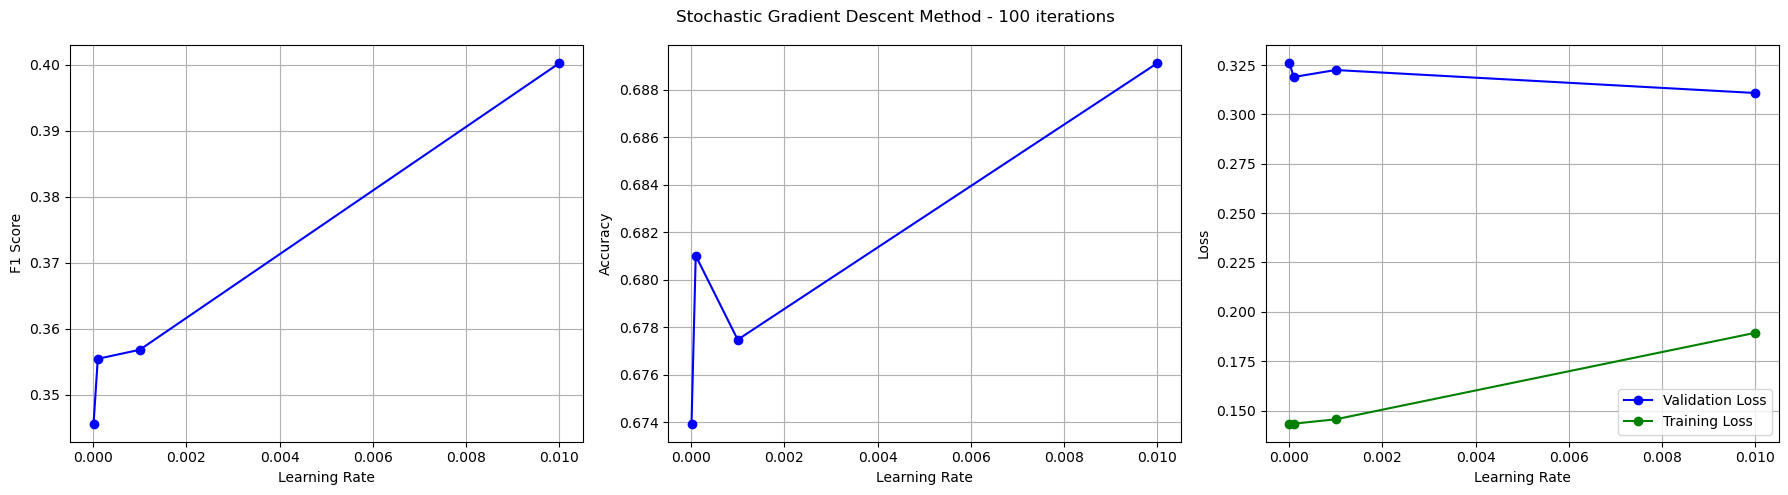

In [26]:
# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot F1 Score
axes[0].plot(np.log(gammas), validation_f1, marker='o', color='b')
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("F1 Score")
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(np.log(gammas), validation_accuracies, marker='o', color='b')
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)

# Plot Loss
axes[2].plot(np.log(gammas),  validation_losses, marker='o', color='b', label='Validation Loss')
axes[2].plot(np.log(gammas),  training_losses, marker='o', color='g', label='Training Loss')
axes[2].set_xlabel("Learning Rate")
axes[2].set_ylabel("Loss")
axes[2].grid(True)
axes[2].legend()


# Adjust layout
fig.suptitle('Stochastic Gradient Descent Method - 100 iterations')
plt.tight_layout()
plt.show()

After finding the best parameter for gamma (gamma = 0.01), it is possible to use the method on way more iterations to see if we get better results and if the method converge to a result.

In [27]:
# Initialize parameters
initial_w = np.zeros((x_train.shape[1]))  
max_iters = 500     #increase iteration from 100 to 500
gamma = 1e-2


# Convert y_train and y_test labels to binary (1, 0) for logistic regression
y_train_bin = np.where(y_train == -1, 0, 1)

#Train Stochastic Gradient Descent with MSE
w, loss = mean_squared_error_sgd(y_train_bin, x_train, initial_w, max_iters, gamma)

#Prediction on the validation set
y_val_pred = np.dot(x_val, w)  
y_val_prob = sigmoid(y_val_pred)
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion to 0 or 1
    
#F1_score and accuracy calculation on validation set
f1 = f1_score(y_val_bin, y_val_pred)

accuracy = np.mean(y_val_pred == y_val_bin)
val_loss = np.mean((y_val_pred - y_val_bin) ** 2)  # MSE for validation set

print(f"F1 score ={f1}, Accuracy = {accuracy}, Validation loss = {val_loss}")

Convergence reached at iteration 110 with tolerance 0.0001 and gamma 0.01
F1 score =0.35184887351580235, Accuracy = 0.6562553925798101, Validation loss = 0.3437446074201898


**3. Least Squares Regression Method**

In [8]:
w, loss = least_squares(y_train_bin.reshape(-1, 1), x_train)
print(f"Least squares method : Loss ={loss}")

#Prediction on the validation set
y_val_pred = np.dot(x_val, w)     
#y_val_pred_prob = sigmoid(y_val_pred)      #transform the score into probability between 0 and 1
y_val_pred = (y_val_pred >= 0).astype(int)  
#y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion into binary value

#for the plot: 
train_losses = []
val_losses = []
max_iters = 1000
for iter in range(max_iters):
    w, train_loss = least_squares(y_train_bin.reshape(-1, 1), x_train)
    val_loss = compute_loss(y_val_bin.reshape(-1, 1), x_val, w)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

#F1_score and accuracy calculation on validation set
f1 = f1_score(y_val_bin, y_val_pred)

accuracy = np.mean(y_val_pred == y_val_bin.reshape(-1, 1))
val_loss = np.mean((y_val_pred - y_val_bin.reshape(-1, 1)) ** 2)  # MSE for validation set

print(f"F1 score ={f1}, Accuracy = {accuracy}, Validation loss = {val_loss}")

Least squares method : Loss =0.08621265997875076
F1 score =0.6615383431037071, Accuracy = 0.5318377911993097, Validation loss = 0.46816220880069026


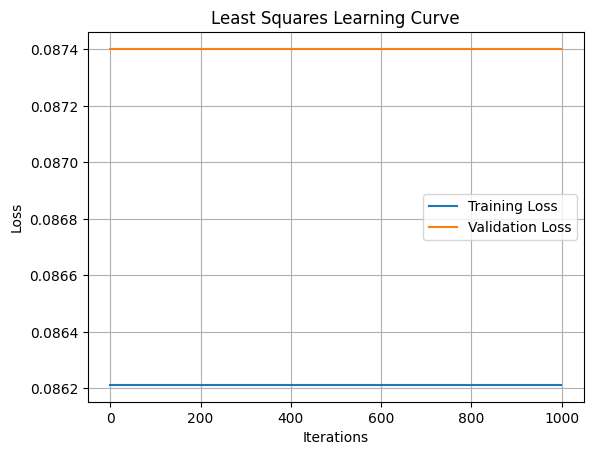

In [9]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Least Squares Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()


The F1 Score is really small (that's bad). The reason could be that least squares are used for linear regression problem rather than classification. 

**4. Ridge Regression Method**

Best lambda is 1e-05 with a loss of 0.07735884315210652
F1 score =0.6526296393467383, Accuracy = 0.5508196721311476, Validation loss = 0.4491803278688525


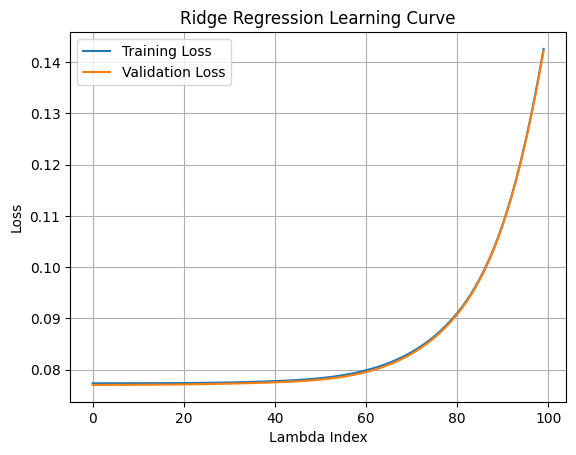

In [7]:
#select a range of values for lambda
lambdas_ = np.logspace(-5, 1, 100)

train_losses_ridge = []
val_losses_ridge = []

#iterate to find the best lambda
for idx, lambda_ in enumerate(lambdas_):
    w, train_loss = ridge_regression(y_train_bin.reshape(-1, 1), x_train, lambda_)
    val_loss = compute_loss(y_val_bin.reshape(-1, 1), x_val, w)

    train_losses_ridge.append(train_loss)
    val_losses_ridge.append(val_loss)

#get the minimum loss and best lambda    
loss = np.min(train_losses_ridge)
lambda_ = lambdas_[train_losses_ridge.index(loss)]

#get the best w associated to the best lambda
best_w_ridge, best_loss = ridge_regression(y_train_bin.reshape(-1, 1), x_train, lambda_)

#get the predicted y values and convert them to binary (0,1)
y_val_pred = np.dot(x_val, best_w_ridge)   
y_val_pred = (y_val_pred >= 0).astype(int)

#compute f1 score, accuracy and validation loss
f1 = f1_score(y_val_bin, y_val_pred)
accuracy = np.mean(y_val_pred == y_val_bin.reshape(-1, 1))
val_loss = np.mean((y_val_pred - y_val_bin.reshape(-1, 1)) ** 2)  # MSE for validation set

print(f"Best lambda is {lambda_} with a loss of {loss}")
print(f"F1 score ={f1}, Accuracy = {accuracy}, Validation loss = {val_loss}")

#plot the learning curve
plt.plot(train_losses_ridge, label='Training Loss')
plt.plot(val_losses_ridge, label='Validation Loss')
plt.title('Ridge Regression Learning Curve')
plt.xlabel('Lambda Index')
plt.ylabel('Loss')
plt.legend()
plt.grid()

Best lambda is 0.35111917342151344 with a training loss of 0.08659330225172883
Best F1 score = 0.6714809720311784, Accuracy = 0.5054357204486627, Validation loss = 0.10593105817511035


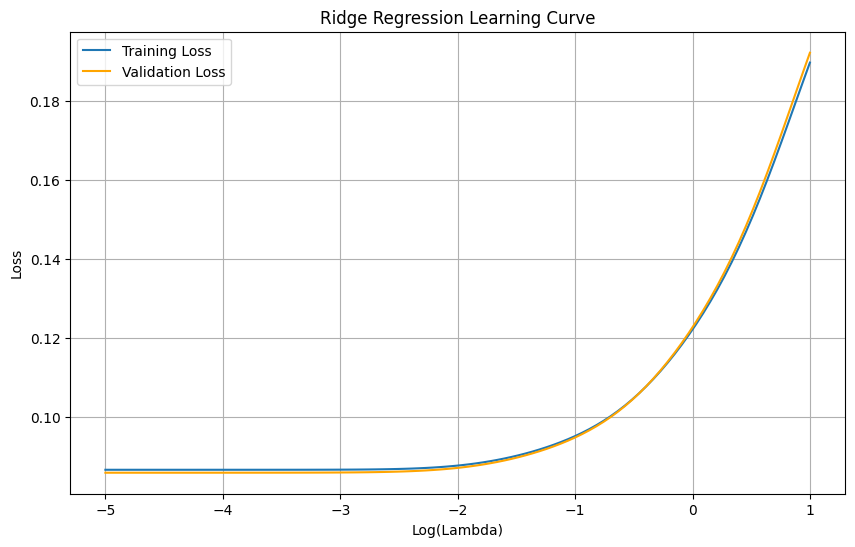

In [18]:
# Range of values for lambda
lambdas_ = np.logspace(-5, 0, 100)

# Initialize lists to store losses
train_losses_ridge = []
val_losses_ridge = []

# Best hyperparameters tracking
best_f1_ridge = 0
best_lambda_ridge = None
best_loss_ridge = None
best_accuracy_ridge = None

# Iterate to find the best lambda
for lambda_ in lambdas_:
    # Train the model with the current lambda
    w, train_loss = ridge_regression(y_train_bin.reshape(-1, 1), x_train, lambda_)
    
    # Calculate validation loss
    val_loss = compute_loss(y_val_bin.reshape(-1, 1), x_val, w)

    # Append losses to their respective lists
    train_losses_ridge.append(train_loss)
    val_losses_ridge.append(val_loss)
    
    # Predictions and metrics on the validation set
    y_val_pred = np.dot(x_val, w)
    y_val_pred = (y_val_pred >= 0).astype(int)
    f1_ridge = f1_score(y_val_bin, y_val_pred)
    accuracy_ridge = np.mean(y_val_pred == y_val_bin.reshape(-1, 1))
    
    # Update best parameters if F1 score improves
    if f1_ridge > best_f1_ridge:
        best_f1_ridge = f1_ridge
        best_lambda_ridge = lambda_
        best_loss_ridge = val_loss
        best_accuracy_ridge = accuracy_ridge

# Output the best lambda and associated metrics
print(f"Best lambda is {best_lambda_ridge} with a training loss of {min(train_losses_ridge)}")
print(f"Best F1 score = {best_f1_ridge}, Accuracy = {best_accuracy_ridge}, Validation loss = {best_loss_ridge}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lambdas_), train_losses_ridge, label='Training Loss')
plt.plot(np.log10(lambdas_), val_losses_ridge, label='Validation Loss', color='orange')
plt.xlabel('Log(Lambda)')
plt.ylabel('Loss')
plt.title('Ridge Regression Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
def k_fold_cross_validation(y, X, lambdas, k=5):
    """Performs k-fold cross-validation on ridge regression model."""
    N = X.shape[0]
    fold_size = N // k
    best_lambda = None
    best_score = -np.inf  # Adjust for metric; start with -inf if using F1
    best_w = None
    validation_scores = []

    for lambda_ in lambdas:
        cv_scores = []

        for fold in range(k):
            # Define validation fold
            val_start = fold * fold_size
            val_end = (fold + 1) * fold_size if fold < k - 1 else N
            X_val_cv, y_val_cv = X[val_start:val_end], y[val_start:val_end]
            # Training folds (all but the validation fold)
            X_train_cv = np.concatenate((X[:val_start], X[val_end:]), axis=0)
            y_train_cv = np.concatenate((y[:val_start], y[val_end:]), axis=0)

            # Train model on training folds
            w, _ = ridge_regression(y_train_cv.reshape(-1, 1), X_train_cv, lambda_)

            # Validate on validation fold
            y_val_pred = (X_val_cv @ w >= 0).astype(int)  # Threshold at 0 for binary
            # Calculate F1 score manually
            '''
            tp = np.sum((y_val_cv == 1) & (y_val_pred == 1))
            fp = np.sum((y_val_cv == 0) & (y_val_pred == 1))
            fn = np.sum((y_val_cv == 1) & (y_val_pred == 0))
            precision = tp / (tp + fp) if tp + fp > 0 else 0
            recall = tp / (tp + fn) if tp + fn > 0 else 0
            f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
            '''
            f1 = f1_score(y_val_cv, y_val_pred)
            cv_scores.append(f1)

        # Average score for this lambda
        avg_score = np.mean(cv_scores)
        validation_scores.append(avg_score)

        # Update best parameters if this lambda's score is better
        if avg_score > best_score:
            best_score = avg_score
            best_lambda = lambda_
            best_w = w

    return best_lambda, best_score, best_w, validation_scores

# Define range of lambda values
lambdas = np.logspace(-4, 1, 50)  # Logarithmic range for lambda

# Run cross-validation to find the best lambda
best_lambda, best_score, best_w, validation_scores = k_fold_cross_validation(y_train_bin, x_train, lambdas, k=5)

print(f"Best lambda: {best_lambda} with cross-validated F1 score: {best_score}")

Best lambda: 0.3727593720314942 with cross-validated F1 score: 0.6654391880361359


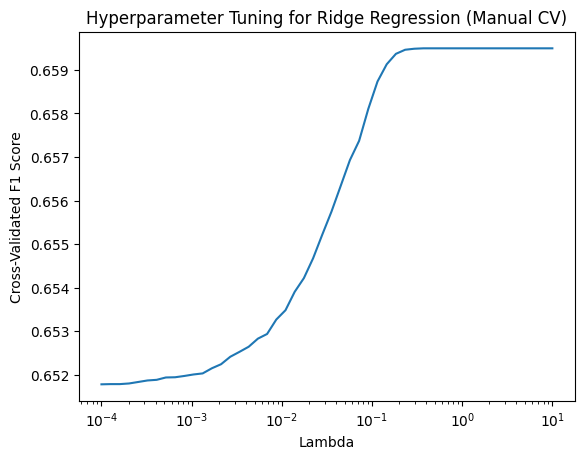

In [18]:
import matplotlib.pyplot as plt

plt.plot(lambdas, validation_scores)
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Cross-Validated F1 Score")
plt.title("Hyperparameter Tuning for Ridge Regression (Manual CV)")
plt.show()

**5.Logistic Regression**

In [14]:
from  implementationsnils import logistic_regression

# Initialize parameters
initial_w = np.zeros((x_train.shape[1], 1))  # assuming x_train has 38 columns after loading
max_iters = 10000
gamma = 0.001

# Train Logistic Regression
w, loss = logistic_regression(y_train_bin.reshape(-1, 1), x_train, initial_w, max_iters, gamma)

y_val_pred = np.dot(x_val, w) 
y_val_pred_prob = sigmoid(y_val_pred) 
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion into binary value    
f1 = f1_score(y_val_bin, y_val_pred)
accuracy = np.mean(y_val_pred == y_val_bin.reshape(-1, 1))
val_loss = np.mean((y_val_pred - y_val_bin.reshape(-1, 1)) ** 2)  # MSE for validation set

#print(f"Best lambda is {lambda_} with a loss of {loss}")
print(f"F1 score ={f1}, Accuracy = {accuracy}, Validation loss = {val_loss}")


F1 score =0.3082510207767117, Accuracy = 0.6443485763589301, Validation loss = 0.3556514236410699


In [5]:
# Define different learning rates (gammas) to test
gammas = [1e-2, 1e-1, 2e-1, 3e-1]  # Step sizes for gradient descent
max_iters_list = [50, 100, 150, 200]

# Best Hyperparameter variables
best_f1 = 0
best_gamma = None
best_max_iters = None
best_loss = None
best_accuracy = None
best_w_GD = None

# Change binary values (-1, 1) of y to binary values (0, 1) for classification
y_train_bin = np.where(y_train == -1, 0, 1)
y_val_bin = np.where(y_val == -1, 0, 1)

# Arrays to store training losses and validation F1 scores
training_losses = np.zeros([len(max_iters_list), len(gammas)])
validation_f1 = np.zeros([len(max_iters_list), len(gammas)])

# Test on the different gammas and iterations
for i, gamma in enumerate(gammas):
    for j, max_iters in enumerate(max_iters_list):
        # Initialize weights
        initial_w = np.zeros((x_train.shape[1]))

        # Train the model on current hyperparameters
        w, train_loss = logistic_regression(y_train_bin.reshape(-1, 1), x_train, initial_w, max_iters, gamma)

        # Prediction on the validation set
        y_val_pred = np.dot(x_val, w)
        y_val_pred_prob = sigmoid(y_val_pred)
        y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

        # F1 score and accuracy calculation on validation set
        f1 = f1_score(y_val_bin, y_val_pred)
        validation_f1[j, i] = f1  # Store F1 score

        # Track best parameters
        if f1 > best_f1:
            best_f1 = f1
            best_gamma = gamma
            best_max_iters = max_iters
            best_loss = train_loss
            best_w_GD = w

        # Store losses for plotting
        training_losses[j, i] = train_loss

# Plot validation F1 scores for each gamma
for i, gamma in enumerate(gammas):
    plt.plot(max_iters_list, validation_f1[:, i], label=f"Gamma: {gamma}")

plt.xlabel("Iterations")
plt.ylabel("Validation F1 Score")
plt.legend()
plt.title("Validation F1 Score for Different Gammas")
plt.show()

print(f"Best gamma: {best_gamma}")
print(f"Best max_iters: {best_max_iters}")
print(f"Best F1 score: {best_f1}")
print(f"Training loss at best parameters: {best_loss}")

: 

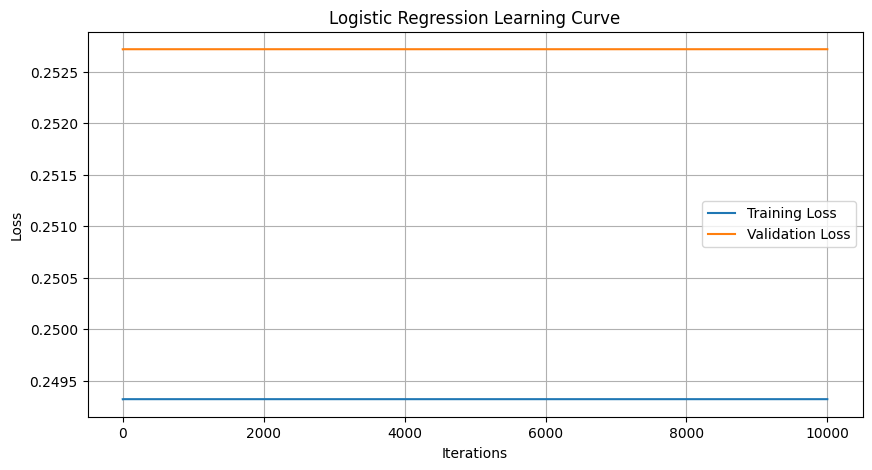

In [15]:
initial_w = np.zeros((x_train.shape[1], 1))
max_iters = 10000
gamma = 0.00001

# Convert y_train labels to binary (1, 0) for logistic regression
y_train_bin = np.where(y_train == -1, 0, 1)

train_losses_logistic = []
val_losses_logistic = []

# Run logistic regression
for iter in range(max_iters):
    w, loss = logistic_regression(y_train_bin.reshape(-1, 1), x_train, initial_w, iter + 1, gamma)
    
    # Calculate training and validation losses
    train_loss = compute_loss(y_train_bin.reshape(-1, 1), x_train, w)
    val_loss = compute_loss(y_val_bin.reshape(-1, 1), x_val, w)
    
    train_losses_logistic.append(train_loss)
    val_losses_logistic.append(val_loss)

# Plotting (as previously shown)
plt.figure(figsize=(10, 5))
plt.plot(train_losses_logistic, label='Training Loss')
plt.plot(val_losses_logistic, label='Validation Loss')
plt.title('Logistic Regression Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

**6. Regularized Logistic Regression**

In [17]:
# Initialize parameters
initial_w = np.zeros((x_train.shape[1], 1))  # assuming x_train has 38 columns after loading
max_iters = 10000
gamma = 0.01
lambda_ = 0.002

# Convert y_train and y_test labels to binary (1, 0) for logistic regression
y_train_bin = np.where(y_train == -1, 0, 1)

# Train Logistic Regression
w, loss = reg_logistic_regression(y_train_bin.reshape(-1, 1), x_train, lambda_, initial_w, max_iters, gamma)

y_val_pred = np.dot(x_val, w) 
y_val_pred_prob = sigmoid(y_val_pred) 
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)  # Conversion into binary value    
f1 = f1_score(y_val_bin, y_val_pred)
accuracy = np.mean(y_val_pred == y_val_bin.reshape(-1, 1))
val_loss = np.mean((y_val_pred - y_val_bin.reshape(-1, 1)) ** 2)  # MSE for validation set

#print(f"Best lambda is {lambda_} with a loss of {loss}")
print(f"F1 score ={f1}, Accuracy = {accuracy}, Validation loss = {val_loss}")

Current iteration=0, loss=0.6931471805599453
Current iteration=100, loss=0.6401823700862533
Current iteration=200, loss=0.6089316859434958
Current iteration=300, loss=0.5887948242089346
Current iteration=400, loss=0.5751034248390243
Current iteration=500, loss=0.565352779721448
Current iteration=600, loss=0.5581328442624023
Current iteration=700, loss=0.552610252193122
Current iteration=800, loss=0.5482692400219897
Current iteration=900, loss=0.5447771589466908
Current iteration=1000, loss=0.5419115990589813
Current iteration=1100, loss=0.5395191706665902
Current iteration=1200, loss=0.5374912296289088
Current iteration=1300, loss=0.5357490413807839
Current iteration=1400, loss=0.5342344046687046
Current iteration=1500, loss=0.532903545547267
Current iteration=1600, loss=0.5317230338251073
Current iteration=1700, loss=0.5306669871398848
Current iteration=1800, loss=0.5297151166183334
Current iteration=1900, loss=0.5288513357050005
Current iteration=2000, loss=0.5280627538736812
Current

In [55]:
initial_w = np.zeros((x_train.shape[1], 1))  # assuming x_train has 38 columns after loading
lambdas = np.logspace(-5, 0, 15)  # Explore a range of lambdas
best_f1 = 0
best_lambda = None
max_iters = 4000
gamma = 0.01

for lambda_ in lambdas:
    w, loss = reg_logistic_regression(y_train_bin.reshape(-1, 1), x_train, lambda_, initial_w, max_iters, gamma)
    
    y_val_pred_prob = sigmoid(np.dot(x_val, w))
    y_val_pred = (y_val_pred_prob >= 0.5).astype(int)
    
    f1 = f1_score(y_val_bin, y_val_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_lambda = lambda_

print(f"Best lambda: {best_lambda}, F1 Score: {best_f1}")

3999


KeyboardInterrupt: 

In [22]:
y_pred_final = (x_test_final @ best_w_GD >= 0).astype(int).ravel()  # Threshold at 0 for binary
y_pred_final = np.where(y_pred_final == 0, -1, 1)

# Generate ids assuming 1-based indexing
#ids = np.arange(328135, len(x_test) + 328135)

In [23]:
create_csv_submission(test_ids, y_pred_final, 'y_pred_sub')